<h1 align="center">Test</h1>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from skimage.color import rgb2gray
from skimage import morphology
from skimage import measure
import copy
import math
import scipy.fftpack as sp

filepath = "test_images/"

def readImage(name):
    return plt.imread(filepath+name)

def displayImage(image,m=1):
    plt.gray()
    plt.imshow(image,vmin=0,vmax=m)
    plt.axis("off")
    plt.show()
    
def getImageMax(image):
    type = image.dtype
    if np.issubdtype(type,np.integer):
        return np.iinfo(type).max
    else:
        return 1
    
def saveImage(image,name):
    plt.imsave(name,image,vmin=0,vmax=getImageMax(image))

<h2>1</h2>

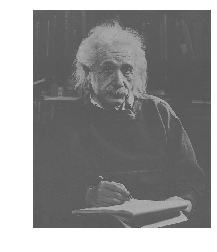

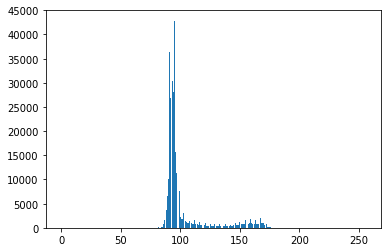

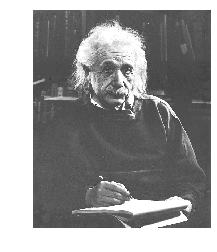

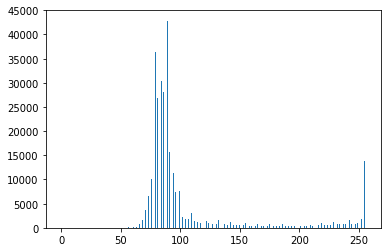

In [9]:
def plotHist(histogram):
    x = np.arange(len(histogram))
    plt.bar(x,histogram)
    plt.show()

def contrastStretch(image,pl,ph,m=255):
    newImage = np.zeros(image.shape).astype(image.dtype)
    for (x,y),value in np.ndenumerate(image):
        newImage[x,y] = piecewise(value,pl,ph,m)
        #break
    return newImage

def piecewise(value,pl,ph,m):
    if value<=pl:
        return 0
    elif value>pl and value<ph:
        return m*(value-pl)/(ph-pl)
    else:
        return m

#Only for ints
def getHistogram(image):
    m = getImageMax(image)
    histogram = np.zeros(m+1)
    for (x,y),value in np.ndenumerate(image):
        histogram[value]+=1
    return histogram

def getProbs(histogram):
    n = np.sum(histogram)
    probs = []
    for i in range(len(histogram)):
        probs.append(histogram[i]/n)
    return probs

def getCumulative(probs):
    return np.cumsum(probs)

def histogramEqualization(image):
    m = getImageMax(image)
    h = getHistogram(image)
    p = getProbs(h)
    c = getCumulative(p)
    newImage = np.zeros(image.shape).astype(image.dtype)
    for (x,y),value in np.ndenumerate(image):
        newImage[x,y] = m*c[value]
    return newImage

einstein = readImage("einstein.tif")
displayImage(einstein,255)
original_hist = getHistogram(einstein)
plotHist(original_hist)

Q_einstein_contrast = contrastStretch(einstein,60,160)
displayImage(Q_einstein_contrast,m=255)
saveImage(Q_einstein_contrast,"Q_einstein_contrast.png")

contrast_hist = getHistogram(Q_einstein_contrast)
plotHist(contrast_hist)

Histogram




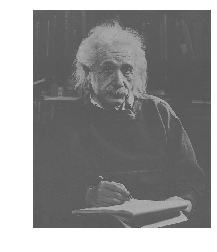

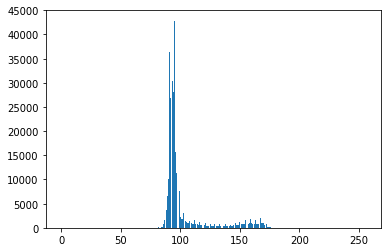

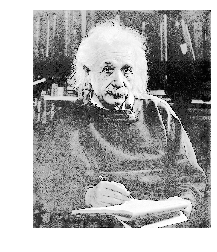

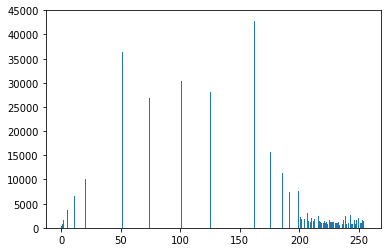

In [10]:
print("Histogram\n\n")
displayImage(einstein,m=255)
plotHist(getHistogram(einstein))

Q_einstein_hist = histogramEqualization(einstein)
displayImage(Q_einstein_hist,m=255)
saveImage(Q_einstein_hist,"Q_einstein_hist.png")
equalized_hist = getHistogram(Q_einstein_hist)
plotHist(equalized_hist)

<h2>2</h2>

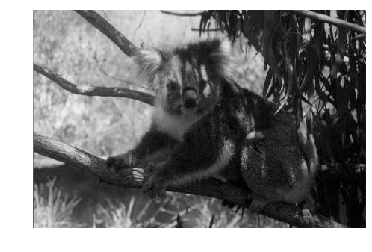

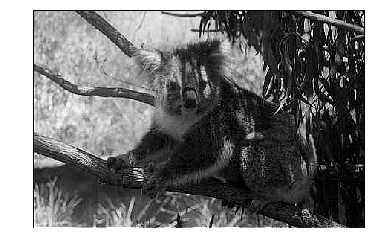

In [11]:
koala = readImage("koala.png")
koala = rgb2gray(koala)
displayImage(koala)

hb = 3*np.array([[0,0,0],[0,1,0],[0,0,0]]) - (2.0/9)*np.ones((3,3))

def applyFilter(f,h):
    offset = math.floor(h.shape[0]/2)
    fp = padZero(f,offset)
    newImage = np.zeros(fp.shape)
    for x in range(offset,fp.shape[0]+offset-1):
        for y in range(offset,f.shape[1]+offset-1):
            g = 0
            for s in range(h.shape[0]):
                for t in range(h.shape[1]):
                    w = h[s,t]
                    F = fp[x-s,y-t]
                    g += w*F
            newImage[x,y] = g
    return dePad(newImage,offset)

def padZero(f,offset):
    fp = np.zeros((f.shape[0]+2*offset,f.shape[1]+2*offset))
    fp[offset:f.shape[0]+offset,offset:f.shape[1]+offset] = f
    return fp

def dePad(f,offset):
    return f[offset:f.shape[0]+offset,offset:f.shape[1]+offset]

Q_koala = applyFilter(koala,hb)
displayImage(Q_koala)
saveImage(Q_koala,"Q_koala.png")

<h2>3</h2>

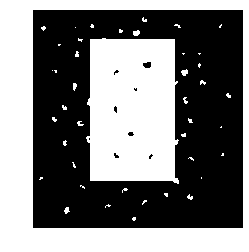

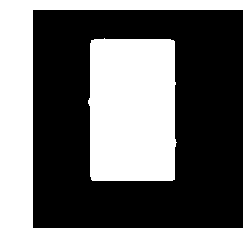

In [12]:
square_noisy = readImage("square_noisy.png").astype(np.bool)
displayImage(square_noisy)

B = morphology.disk(13)

def removeSaltAndPepper(image,B):
    im_open = morphology.binary_opening(image,B)
    im_close = morphology.binary_closing(im_open,B)
    return im_close

Q_square = removeSaltAndPepper(square_noisy,B)
displayImage(Q_square)
saveImage(Q_square,"Q_square.png")

<h2>4</h2>

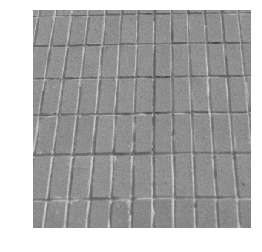

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


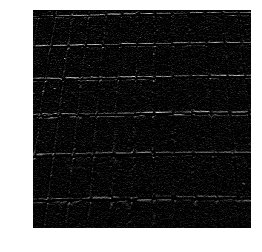

In [13]:
def DFTFilter(f,h):
    A = f.shape[0]
    B = f.shape[1]
    C = h.shape[0]
    D = h.shape[1]
    P = nextPow2(A+C-1)
    Q = nextPow2(B+D-1)
    fp = np.zeros((P,Q))
    hp = np.zeros((P,Q))
    fp[0:A,0:B] = f
    hp[0:C,0:D] = h
    
    F = sp.fft2(fp)
    H = sp.fft2(hp)
    G = H*F
    g = sp.ifft2(G)
    return np.real(g[0:A,0:B])
    

def nextPow2(x):
    p = 1
    while 2**p < x:
        p+=1
    return 2**p

brick = readImage("brick.png")
Sobel = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
displayImage(brick)
Q_brick = DFTFilter(brick,Sobel)
displayImage(Q_brick)
saveImage(Q_brick,"Q_brick.png")

<h2>5</h2>

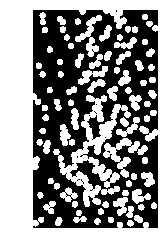

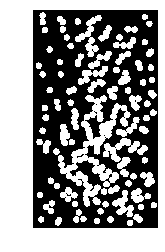

In [14]:
particles = readImage("particles.tif").astype(np.bool)
displayImage(particles)

B = morphology.disk(3)

def dePad(f,offset):
    return f[offset:f.shape[0]+offset,offset:f.shape[1]+offset]

def padOne(f,offset):
    fp = np.ones((f.shape[0]+2*offset,f.shape[1]+2*offset))
    fp[offset:f.shape[0]+offset,offset:f.shape[1]+offset] = f
    return fp

def cleanupBorder(image,B):
    offset = 1
    padded = padOne(image,offset).astype(np.bool)
    label = measure.label(padded)
    myLabel = label[0,0]
    newImage = np.zeros(padded.shape)
    for (x,y),value in np.ndenumerate(label):
        if value == myLabel or value == 0:
            newImage[x,y] = 0
        else:
            newImage[x,y] = 1
    return dePad(newImage,offset)
    
    
    
Q_particles = cleanupBorder(particles,B)
displayImage(Q_particles)
saveImage(Q_particles,"Q_particles.png")

In [15]:
help(measure.label)

Help on function label in module skimage.measure._label:

label(input, neighbors=None, background=None, return_num=False, connectivity=None)
    Label connected regions of an integer array.
    
    Two pixels are connected when they are neighbors and have the same value.
    In 2D, they can be neighbors either in a 1- or 2-connected sense.
    The value refers to the maximum number of orthogonal hops to consider a
    pixel/voxel a neighbor::
    
      1-connectivity      2-connectivity     diagonal connection close-up
    
           [ ]           [ ]  [ ]  [ ]         [ ]
            |               \  |  /             |  <- hop 2
      [ ]--[x]--[ ]      [ ]--[x]--[ ]    [x]--[ ]
            |               /  |  \         hop 1
           [ ]           [ ]  [ ]  [ ]
    
    Parameters
    ----------
    input : ndarray of dtype int
        Image to label.
    neighbors : {4, 8}, int, optional
        Whether to use 4- or 8-"connectivity".
        In 3D, 4-"connectivity" means co